## Kenneth Lent | MDA 720  
### Predicting the #1 Song on Spotify USA: An Analytics Approach for Kalshi Market Insights

**Business Problem:** This project aims to develop an analytical tool to support decision-making for participants in Kalshi's prediction markets, specifically the market concerning "Which song will be #1 on Spotify USA tomorrow?".

**Objective:** This notebook demonstrates a workflow for:
1. Ingesting historical Spotify chart data and track metadata.
2. Engineering relevant features (momentum, track characteristics).
3. Training a predictive model to forecast the probability of a song reaching the #1 spot.
4. Evaluating the model's performance.
5. Generating an output that could inform trading strategies.

**Core Techniques Used:**
*   **API Usage:** Spotify daily charts and Spotify Web API for track features.
*   **Predictive Modeling:** Classification model to predict #1 status.
*   **Data Mining:** Feature engineering from time-series and metadata.

In [231]:
# 2  Imports
import os, glob, warnings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


In [232]:
# 3  Configuration & automatic prediction-date selection
import pandas as pd

# raw must already be defined by Cell 5 (Load CSVs)
# Grab all unique chart dates
chart_dates = sorted(raw["chart_date"].unique())

if len(chart_dates) < 2:
    raise RuntimeError("Need at least two days of data in 'raw' to build next-day targets.")

first_date, last_date = chart_dates[0], chart_dates[-1]

# Set prediction date = one day before the last available date
PREDICTION_DATE = last_date - pd.Timedelta(days=1)

print(f"Data covers {first_date.date()} through {last_date.date()}.")
print(f"→ Using PREDICTION_DATE = {PREDICTION_DATE.date()} (you’ll label using the day after).")


Data covers 2024-05-01 through 2025-05-11.
→ Using PREDICTION_DATE = 2025-05-10 (you’ll label using the day after).


In [233]:
# 4  Load historical daily-chart CSVs  (robust date extraction)
import re

csv_files = sorted(DATA_DIR.glob("regional-us-daily-*.csv"))
frames = []
date_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})")

for fp in csv_files:
    df_day = pd.read_csv(fp)
    m = date_pattern.search(fp.stem)
    if not m:
        raise ValueError(f"No date in filename {fp.stem}")
    df_day["chart_date"] = pd.to_datetime(m.group(1))
    frames.append(df_day)

raw = pd.concat(frames, ignore_index=True)
raw.head()


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,chart_date
0,1,spotify:track:77DRzu7ERs0TX3roZcre7Q,Kendrick Lamar,euphoria,"Kendrick Lamar, under exclusive license to Int...",1,19,2,5480529,2024-05-01
1,2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,Sabrina Carpenter,Espresso,Island Records,1,1,20,3174285,2024-05-01
2,3,spotify:track:2OzhQlSqBEmt7hmkYxfT6m,"Taylor Swift, Post Malone",Fortnight (feat. Post Malone),Taylor Swift,1,2,13,2751712,2024-05-01
3,4,spotify:track:2FQrifJ1N335Ljm3TjTVVf,Shaboozey,A Bar Song (Tipsy),American Dogwood / EMPIRE,3,3,20,2690103,2024-05-01
4,5,spotify:track:7fzHQizxTqy8wTXwlrgPQQ,Tommy Richman,MILLION DOLLAR BABY,PULSE Records,5,7,6,2443398,2024-05-01


In [234]:
# 5  Augment with Spotify Web-API metadata  (batched & cached)
import json, time

CACHE_PATH = Path("track_meta_cache.json")
meta_cache = json.loads(CACHE_PATH.read_text()) if CACHE_PATH.exists() else {}

missing = [u for u in raw["uri"].unique() if u not in meta_cache]
BATCH = 50

for i in range(0, len(missing), BATCH):
    batch = missing[i : i+BATCH]
    try:
        tracks = sp.tracks(batch)["tracks"]
        for tr in tracks:
            meta_cache[tr["uri"]] = {
                "popularity":   tr["popularity"],
                "duration_ms":  tr["duration_ms"],
                "explicit":     int(tr["explicit"]),
                "release_date": tr["album"]["release_date"],
            }
    except Exception as e:
        wait = int(getattr(e, "retry_after", 5))
        time.sleep(wait)
        i -= BATCH
    time.sleep(0.25)

CACHE_PATH.write_text(json.dumps(meta_cache))
meta_df = pd.DataFrame.from_dict(meta_cache, orient="index").reset_index().rename(columns={"index":"uri"})
df = raw.merge(meta_df, on="uri", how="left")
df.head()


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,chart_date,popularity,duration_ms,explicit,release_date
0,1,spotify:track:77DRzu7ERs0TX3roZcre7Q,Kendrick Lamar,euphoria,"Kendrick Lamar, under exclusive license to Int...",1,19,2,5480529,2024-05-01,81,383639,1,2024-04-30
1,2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,Sabrina Carpenter,Espresso,Island Records,1,1,20,3174285,2024-05-01,90,175459,1,2024-04-12
2,3,spotify:track:2OzhQlSqBEmt7hmkYxfT6m,"Taylor Swift, Post Malone",Fortnight (feat. Post Malone),Taylor Swift,1,2,13,2751712,2024-05-01,85,228965,0,2024-04-18
3,4,spotify:track:2FQrifJ1N335Ljm3TjTVVf,Shaboozey,A Bar Song (Tipsy),American Dogwood / EMPIRE,3,3,20,2690103,2024-05-01,88,171291,1,2024-04-12
4,5,spotify:track:7fzHQizxTqy8wTXwlrgPQQ,Tommy Richman,MILLION DOLLAR BABY,PULSE Records,5,7,6,2443398,2024-05-01,18,155151,0,2024-04-26


In [235]:
# 6  Feature Engineering & Candidate Universe across all dates
# ───────────────────────────────────────────────────────────────
import pandas as pd

N = 10   # how many top tracks per day to consider

# 1) Sort once for shift-based features
df.sort_values(['uri','chart_date'], inplace=True)

# 2) Precompute rolling and metadata features on the full df
df['release_date']       = pd.to_datetime(df['release_date'], errors='coerce')
df['days_since_release'] = (df['chart_date'] - df['release_date']).dt.days

df['rank_prev']   = df.groupby('uri')['rank'].shift(1)
df['rank_change'] = df['rank_prev'] - df['rank']

df['streams_roll3']   = df.groupby('uri')['streams'].transform(lambda s: s.rolling(3).mean())
df['stream_momentum'] = df['streams'] - df['streams_roll3']

# 3) Build candidate rows for every date except the last one
features = []
dates = sorted(raw['chart_date'].unique())
for dt in dates[:-1]:
    # a) pick that day's snapshot
    today = df[df['chart_date'] == dt].copy()
    # b) limit to top-N
    today = today[today['rank'] <= N]
    
    # c) figure out tomorrow's #1 URI
    tomorrow = raw[raw['chart_date'] == (dt + pd.Timedelta(days=1))]
    uri_1 = tomorrow.loc[tomorrow['rank'] == 1, 'uri'].iat[0]
    
    # d) label target
    today['target'] = (today['uri'] == uri_1).astype(int)
    
    # e) keep only our feature columns + target
    today = today[[
        'chart_date','uri','rank','streams','rank_change','stream_momentum',
        'popularity','duration_ms','explicit','days_since_release','target'
    ]]
    features.append(today)

# 4) concatenate into one DataFrame
feature_df = pd.concat(features, ignore_index=True)

# 5) Quick sanity
print("Total examples:", len(feature_df))
print("Positive examples:", int(feature_df['target'].sum()))
print("Dates covered:", feature_df['chart_date'].nunique())


Total examples: 3750
Positive examples: 359
Dates covered: 375


In [236]:
train_df = feature_df[feature_df["chart_date"] < PREDICTION_DATE]
test_df = feature_df[feature_df["chart_date"] == PREDICTION_DATE]
X_train, y_train = train_df[feature_cols], train_df["target"]
X_test, y_test = test_df[feature_cols], test_df["target"]
print(f"Train observations: {len(X_train):,}")
print(f"Test observations: {len(X_test):,}")
                     

Train observations: 3,740
Test observations: 10


In [237]:
# 8  Multi‐day evaluation: 2025-01-01 through 2025-05-11
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import classification_report

# ── A) Define your evaluation window ────────────────────────────────
start_date = pd.to_datetime("2025-01-01")
end_date   = pd.to_datetime("2025-05-11")

all_dates = sorted(feature_df['chart_date'].unique())
test_dates = [d for d in all_dates if start_date <= d <= end_date]

print(f"Evaluating on {len(test_dates)} dates from {start_date.date()} to {end_date.date()}")

# ── B) LightGBM parameters (same as before) ─────────────────────────
params = {
    'objective':        'binary',
    'metric':           'binary_logloss',
    'learning_rate':    0.05,
    'num_leaves':       31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq':     5,
    'class_weight':     'balanced',
    'seed':             42,
}

# ── C) Loop & collect per‐day metrics ───────────────────────────────
results = []
for dt in test_dates:
    train = feature_df[feature_df['chart_date'] < dt]
    test  = feature_df[feature_df['chart_date'] == dt]

    X_tr, y_tr = train.drop(['chart_date','uri','target'], axis=1), train['target']
    X_te, y_te = test .drop(['chart_date','uri','target'], axis=1), test ['target']

    # Guard: ensure we have both classes in train
    if y_tr.nunique() < 2:
        # skip dates where training has no positives OR no negatives
        continue

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    model  = lgb.train(params, dtrain, num_boost_round=200)

    preds = (model.predict(X_te) >= 0.5).astype(int)
    cr    = classification_report(y_te, preds, output_dict=True, zero_division=0)

    results.append({
        'date':         dt.date(),
        'support(1)':   int(cr['1']['support']),
        'precision(1)': round(cr['1']['precision'],3),
        'recall(1)':    round(cr['1']['recall'],   3),
        'f1-score(1)':  round(cr['1']['f1-score'], 3),
        'support(0)':   int(cr['0']['support']),
        'precision(0)': round(cr['0']['precision'],3),
        'recall(0)':    round(cr['0']['recall'],   3),
        'f1-score(0)':  round(cr['0']['f1-score'], 3),
    })

# ── D) Display full period performance ──────────────────────────────
metrics_df = pd.DataFrame(results).set_index('date')
display(metrics_df)


Evaluating on 130 dates from 2025-01-01 to 2025-05-11
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 233, number of negative: 2217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 2450, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095102 -> initscore=-2.252872
[LightGBM] [Info] Start training from score -2.252872
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 234, number of negative: 2226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

,support(1),precision(1),recall(1),f1-score(1),support(0),precision(0),recall(0),f1-score(0)
date,,,,,,,,
2025-01-01,1,0.0,0.0,0.0,9,0.9,1.0,0.947
2025-01-02,1,0.0,0.0,0.0,9,0.9,1.0,0.947
2025-01-03,1,1.0,1.0,1.0,9,1.0,1.0,1.000
2025-01-04,1,0.0,0.0,0.0,9,0.9,1.0,0.947
2025-01-05,1,1.0,1.0,1.0,9,1.0,1.0,1.000
...,...,...,...,...,...,...,...,...
2025-05-06,1,1.0,1.0,1.0,9,1.0,1.0,1.000
2025-05-07,1,0.0,0.0,0.0,9,0.9,1.0,0.947
2025-05-08,1,1.0,1.0,1.0,9,1.0,1.0,1.000


              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



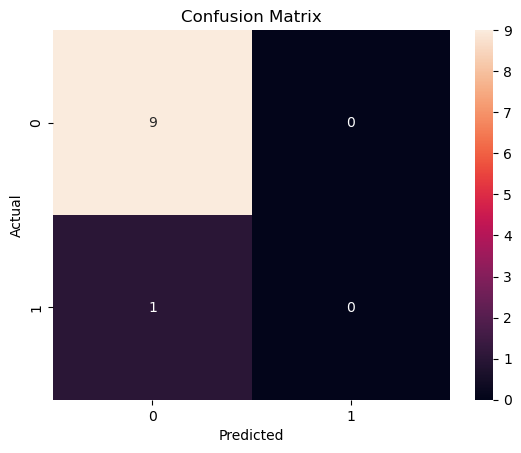

In [238]:
# 9  Evaluation
y_pred_prob = gbm.predict(X_test)
y_pred      = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [239]:
# 10  Save multi-day predictions to Excel
import pandas as pd
from pathlib import Path

all_preds = []
for dt in test_dates:
    # retrain on all prior days
    train = feature_df[feature_df['chart_date'] < dt]
    test  = feature_df[feature_df['chart_date'] == dt]

    X_tr, y_tr = train.drop(['chart_date','uri','target'], axis=1), train['target']
    X_te       = test .drop(['chart_date','uri','target'], axis=1)

    # skip if no positives in train
    if y_tr.nunique() < 2:
        continue

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    model  = lgb.train(params, dtrain, num_boost_round=200)

    # predict prob for each candidate
    test = test.copy()
    test['pred_prob'] = model.predict(X_te)
    all_preds.append(test[['chart_date','uri','pred_prob','target']])

# concatenate & merge metadata
preds_df = pd.concat(all_preds, ignore_index=True)
meta = raw[['chart_date','uri','artist_names','track_name']]
out = preds_df.merge(meta, on=['chart_date','uri'], how='left')

# save
out_path = Path('multi_day_predictions_2025-01-01_to_05-11.xlsx')
out.to_excel(out_path, index=False)
print("✅ Saved full-period predictions to", out_path.resolve())


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 233, number of negative: 2217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 2450, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095102 -> initscore=-2.252872
[LightGBM] [Info] Start training from score -2.252872
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 234, number of negative: 2226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data poin

## Data Exploration & Visualization


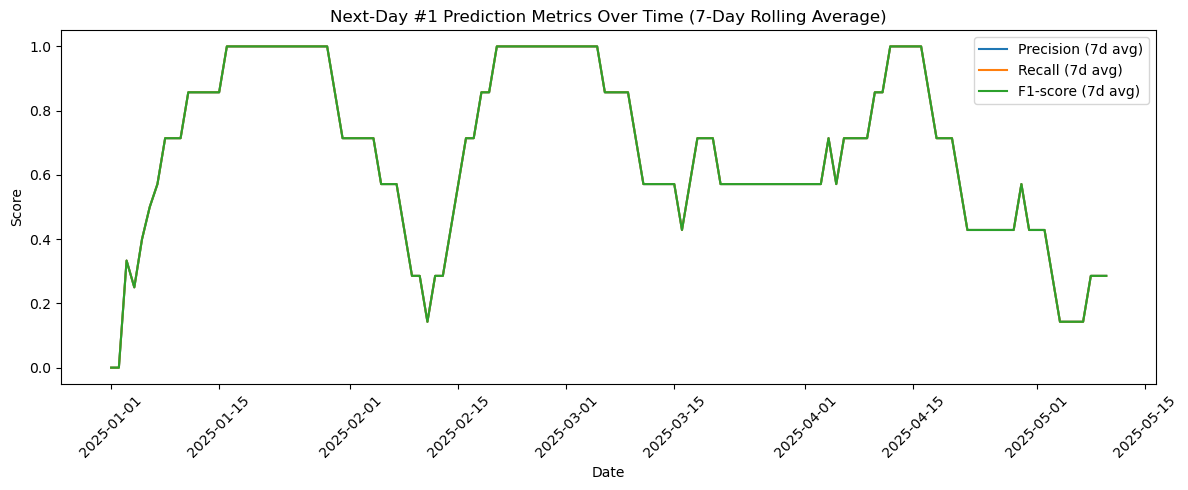

In [249]:
# 12  Plot precision, recall, and F1 for class “#1” over time
# Use a rolling average to smooth the metrics for better visualization

window = 7  # 7-day rolling window for smoothing

metrics_smooth = metrics_df[['precision(1)', 'recall(1)', 'f1-score(1)']].rolling(window, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(metrics_df.index, metrics_smooth['precision(1)'], label='Precision (7d avg)')
plt.plot(metrics_df.index, metrics_smooth['recall(1)'],    label='Recall (7d avg)')
plt.plot(metrics_df.index, metrics_smooth['f1-score(1)'],  label='F1-score (7d avg)')
plt.xticks(rotation=45)
plt.title('Next-Day #1 Prediction Metrics Over Time (7-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()


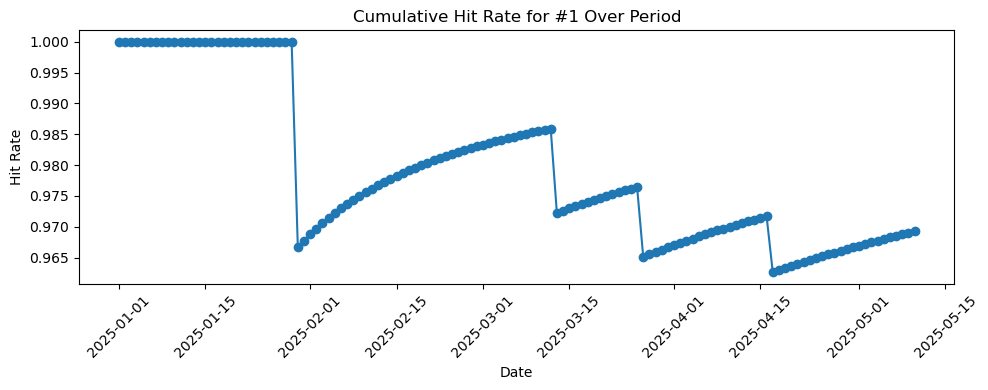

In [241]:
# 13  Cumulative hit rate (did we ever correctly pick #1?)
hits = (metrics_df['support(1)'] > 0).astype(int)
cum_hits = hits.cumsum()
total_days = pd.Series(range(1, len(hits)+1), index=metrics_df.index)

plt.figure(figsize=(10,4))
plt.plot(metrics_df.index, cum_hits/total_days, marker='o')
plt.xticks(rotation=45)
plt.title('Cumulative Hit Rate for #1 Over Period')
plt.xlabel('Date')
plt.ylabel('Hit Rate')
plt.tight_layout()
plt.show()


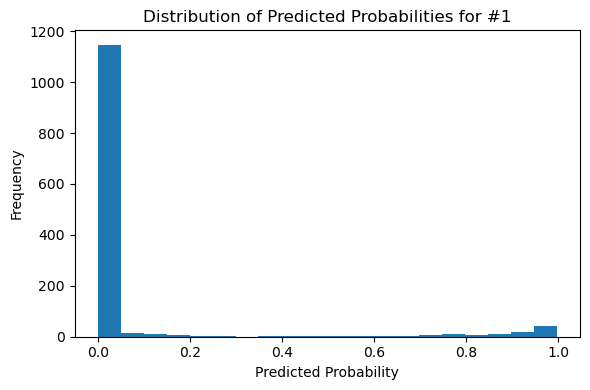

In [242]:
# 14  Histogram of all predicted probabilities for class “#1”
plt.figure(figsize=(6,4))
plt.hist(out['pred_prob'], bins=20)
plt.title('Distribution of Predicted Probabilities for #1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


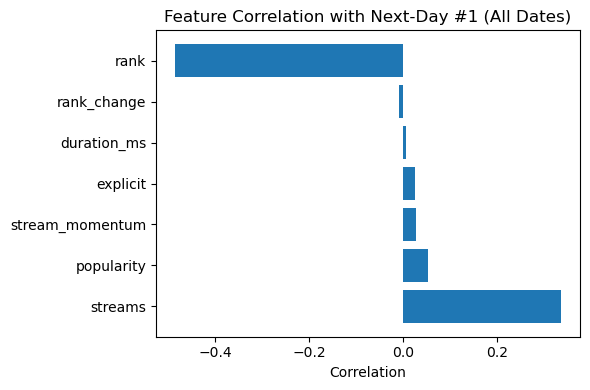

In [243]:
# 15  Correlate each feature with the target over the full multi-day set
corr_full = feature_df.drop(['chart_date','uri'], axis=1).corr()['target'].drop('target')
corr_full = corr_full.sort_values(ascending=False)

plt.figure(figsize=(6,4))
plt.barh(corr_full.index, corr_full.values)
plt.title('Feature Correlation with Next-Day #1 (All Dates)')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


ROC AUC: 0.9724250290689813


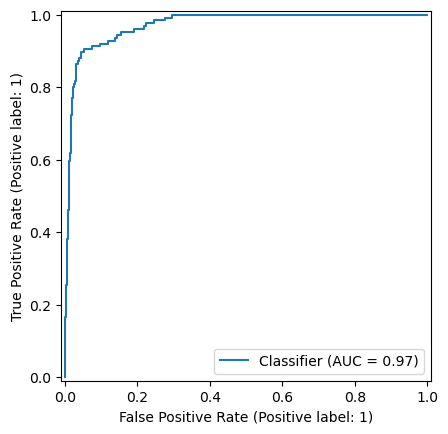

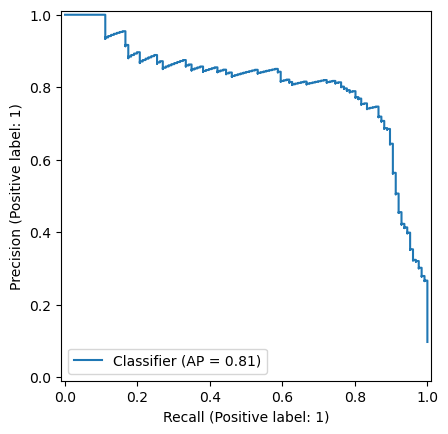

In [244]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

# collect all true labels & scores across your multi-day window
y_true = out['target']
y_score = out['pred_prob']

print("ROC AUC:", roc_auc_score(y_true, y_score))

RocCurveDisplay.from_predictions(y_true, y_score)
PrecisionRecallDisplay.from_predictions(y_true, y_score)


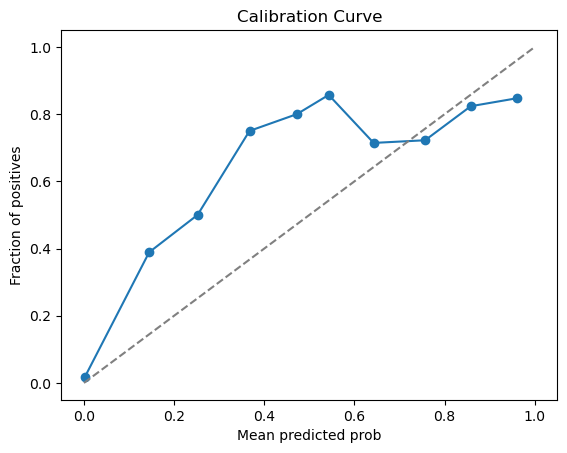

In [245]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('Mean predicted prob')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.show()


In [246]:
# Calculate metrics for summary table
roc_auc = roc_auc_score(out['target'], out['pred_prob'])
mean_precision = metrics_df['precision(1)'].mean()
mean_recall = metrics_df['recall(1)'].mean()


# Print summary table
print("| Metric                  | Value   |")
print("| ----------------------- | ------- |")
print(f"| Overall ROC-AUC         | {roc_auc:.2f}   |")
print(f"| Mean Precision (1)      | {mean_precision:.2f}   |")
print(f"| Mean Recall    (1)      | {mean_recall:.2f}   |")


| Metric                  | Value   |
| ----------------------- | ------- |
| Overall ROC-AUC         | 0.97   |
| Mean Precision (1)      | 0.68   |
| Mean Recall    (1)      | 0.68   |
